In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import numpy as np

DATADIR = "C:/Users/HP/Documents/Documents/Documents/Masters/Course documents/Fall 2020/IE7315 Neural Network and Deep Learning/Project Files/Nuance captures"
IMAGES = ["Thermal"]

for image in IMAGES:  # do dogs and cats
    path = os.path.join(DATADIR,image)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break 
    break 
    

In [ ]:
print(img_array.shape)

In [ ]:
IMG_SIZE = 500

new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap='gray')
plt.show()

In [ ]:
training_data = []

def create_training_data():
    for image in IMAGES:  # do dogs and cats
        path = os.path.join(DATADIR,image)  # create path to dogs and cats
        class_num = IMAGES.index(image)
        for img in os.listdir(path):  # iterate over each image per dogs and cats
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            training_data.append([new_array, class_num])
        
create_training_data()



In [ ]:
print(len(training_data))

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose



In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [3]:
filename = next(os.walk("Thermal"))[2] # list of names all images in the given path
print("No. of images = ", len(filename))


No. of images =  1806


In [4]:
X = np.zeros((len(filename), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(filename), im_height, im_width, 1), dtype=np.float32)

In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(filename), total=len(filename)):
    # Load images
    img = load_img("Thermal/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("Annos/"+id_))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-5-bcfa8638deab>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(filename), total=len(filename)):


In [6]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

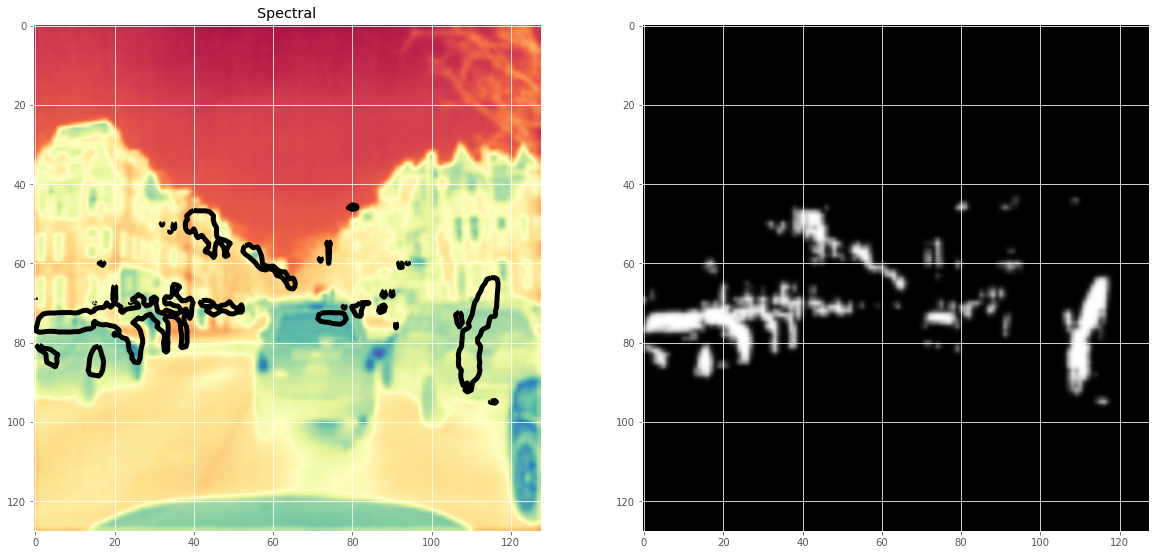

In [7]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'Spectral', interpolation = 'gaussian')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Spectral')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'gaussian')
# ax2.set_title('binary')

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [9]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [12]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.7816
Epoch 00001: val_loss improved from 0.15515 to 0.14843, saving model to model1.h5
40/40 [==============================] - 93s 2s/step - loss: 0.1418 - accuracy: 0.7816 - val_loss: 0.1484 - val_accuracy: 0.7866
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.7816
Epoch 00002: val_loss improved from 0.14843 to 0.14121, saving model to model1.h5
40/40 [==============================] - 94s 2s/step - loss: 0.1379 - accuracy: 0.7816 - val_loss: 0.1412 - val_accuracy: 0.7866
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.7816
Epoch 00003: val_loss improved from 0.14121 to 0.13706, saving model to model1.h5
40/40 [==============================] - 96s 2s/step - loss: 0.1347 - accuracy: 0.7816 - val_loss: 0.1371 - val_accuracy: 0.7866
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 0.1319 - accu

Epoch 29/100
40/40 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.7810
Epoch 00029: val_loss improved from 0.11885 to 0.11837, saving model to model1.h5
40/40 [==============================] - 88s 2s/step - loss: 0.0972 - accuracy: 0.7810 - val_loss: 0.1184 - val_accuracy: 0.7851
Epoch 30/100
40/40 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.7810
Epoch 00030: val_loss improved from 0.11837 to 0.11770, saving model to model1.h5
40/40 [==============================] - 88s 2s/step - loss: 0.0959 - accuracy: 0.7810 - val_loss: 0.1177 - val_accuracy: 0.7849
Epoch 31/100
40/40 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.7811
Epoch 00031: val_loss did not improve from 0.11770
40/40 [==============================] - 90s 2s/step - loss: 0.0952 - accuracy: 0.7811 - val_loss: 0.1177 - val_accuracy: 0.7847
Epoch 32/100
40/40 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.7811
Epoch 00032: v

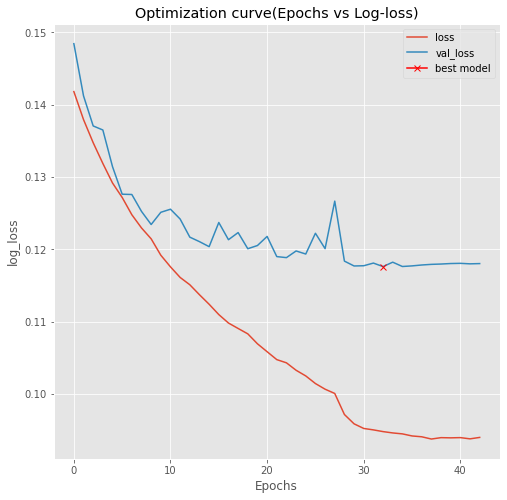

In [15]:

plt.figure(figsize=(8, 8))
plt.title("Optimization curve(Epochs vs Log-loss)")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# Inference


In [16]:
# load the best model
model.load_weights('model1.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

17/17 [==============================] - 6s 324ms/step - loss: 0.1176 - accuracy: 0.7847


[0.11761445552110672, 0.784717857837677]

In [17]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

17/17 [==============================] - 5s 313ms/step


In [18]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [19]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='coolwarm')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('segmented mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted segmentation')


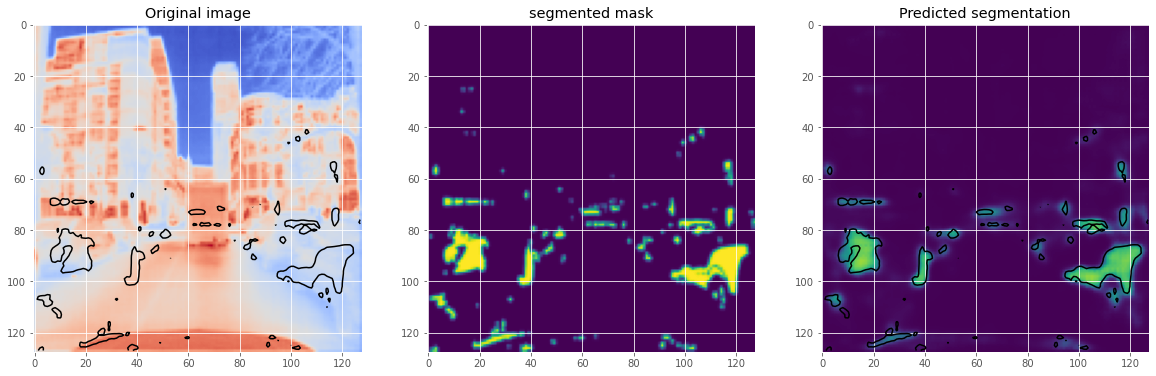

In [20]:
##Predictions on training set

# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

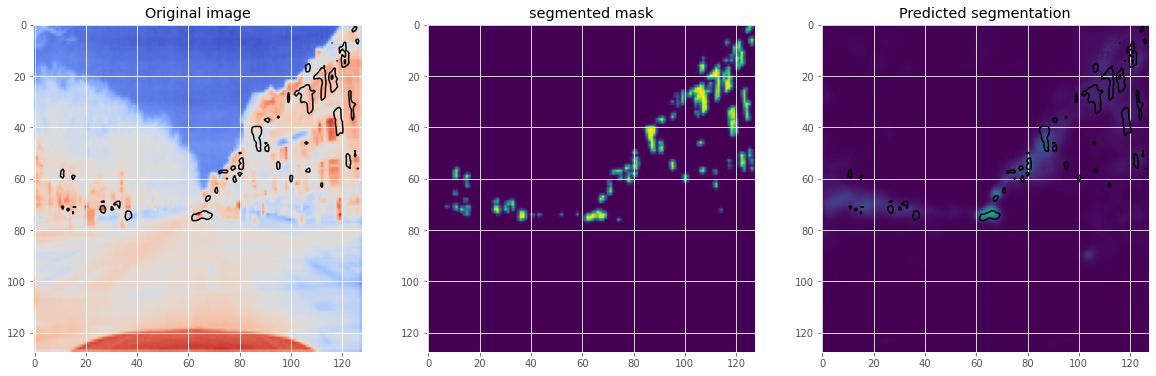

In [21]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

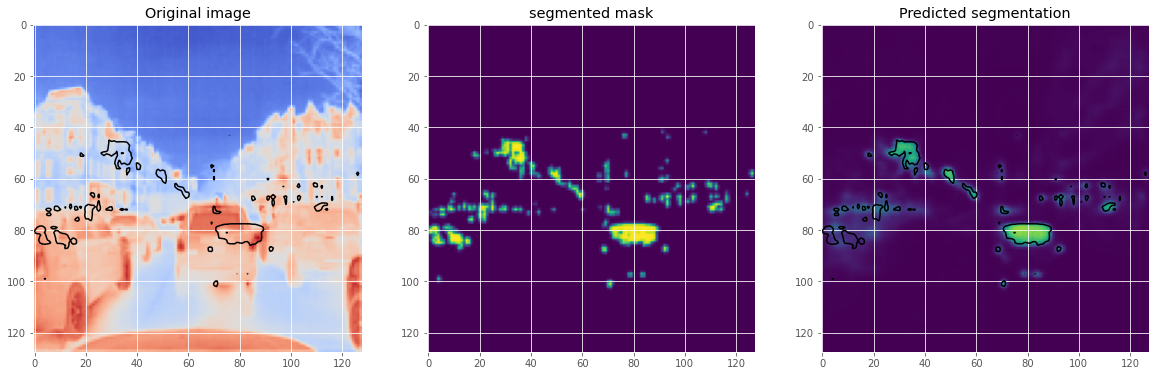

In [22]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


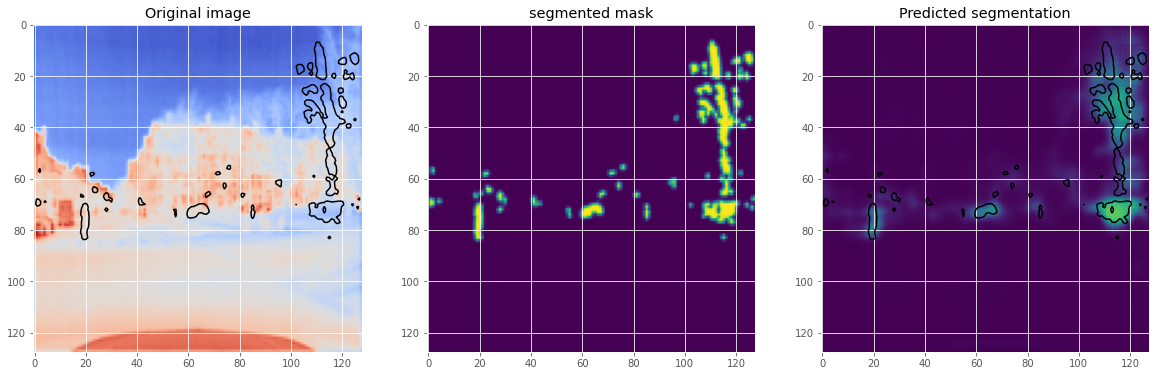

In [23]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


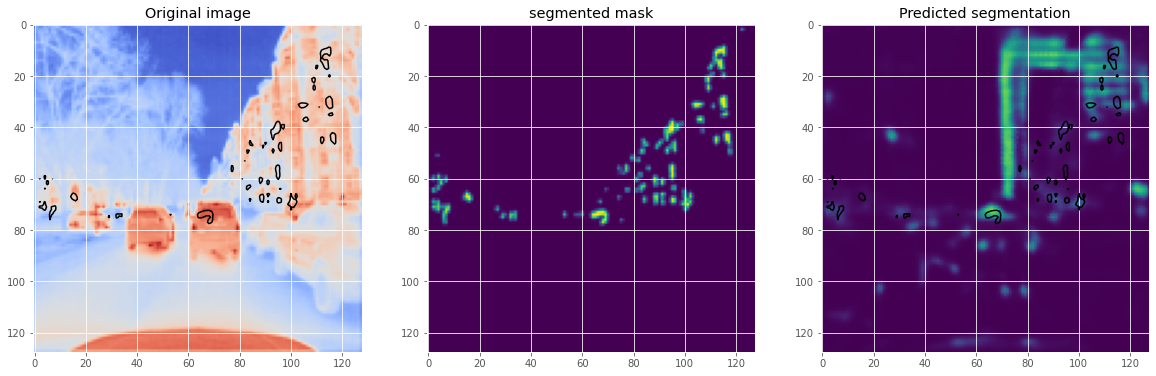

In [24]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


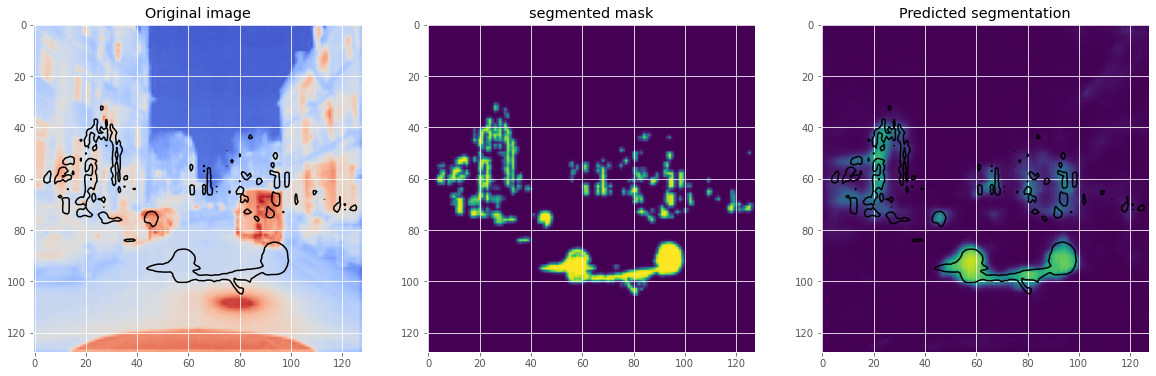

In [25]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


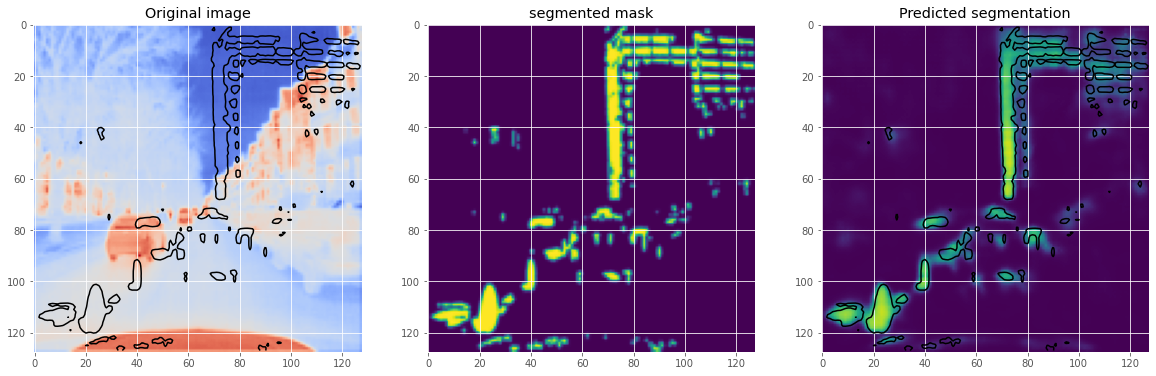

In [26]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


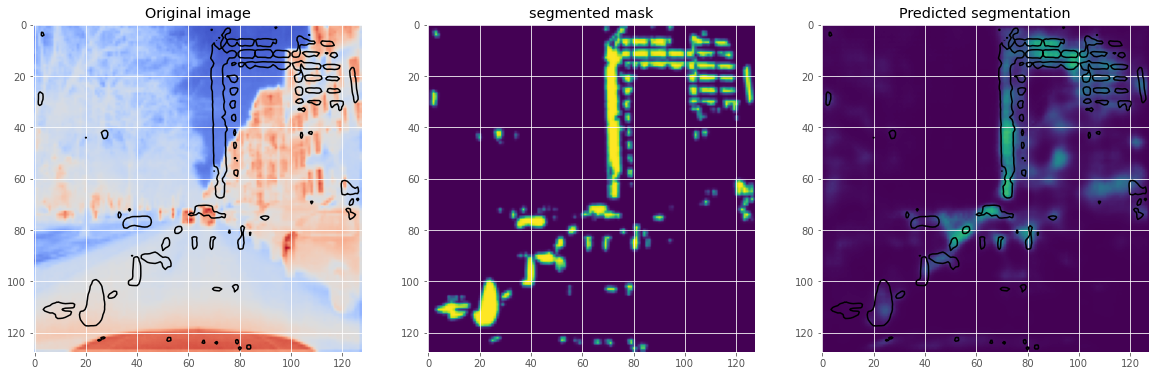

In [27]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)


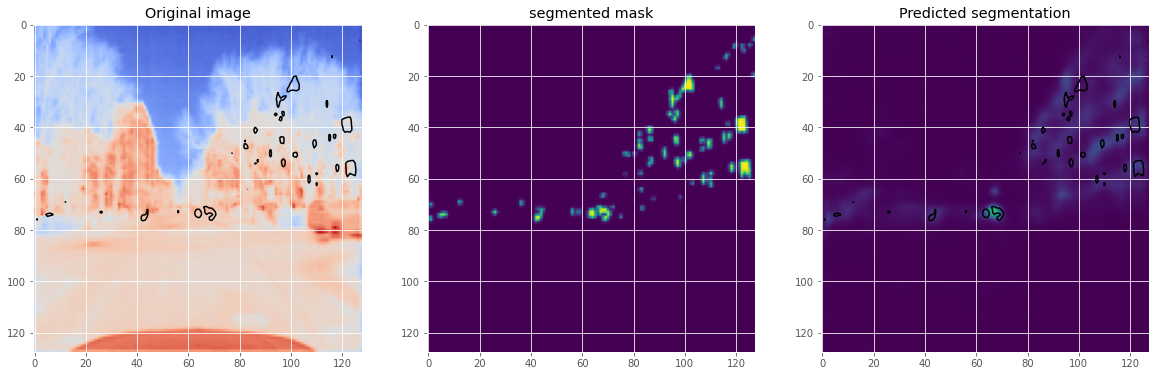

In [28]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

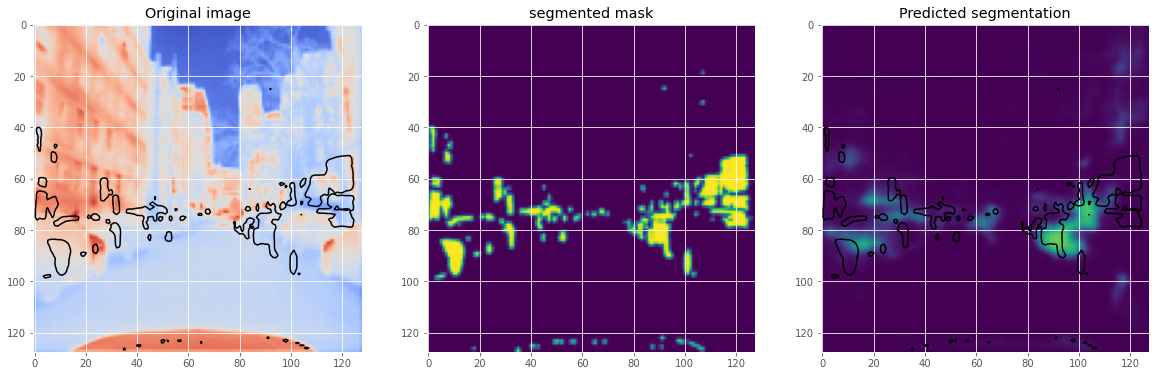

In [29]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)


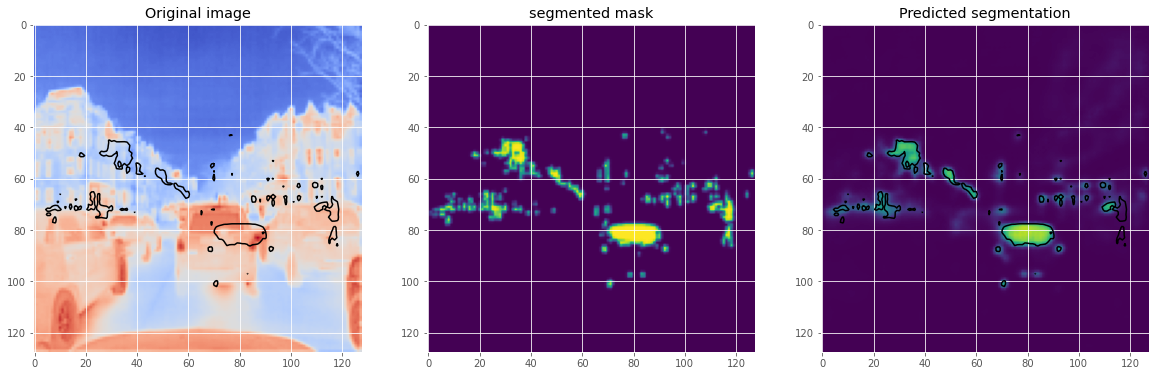

In [30]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)


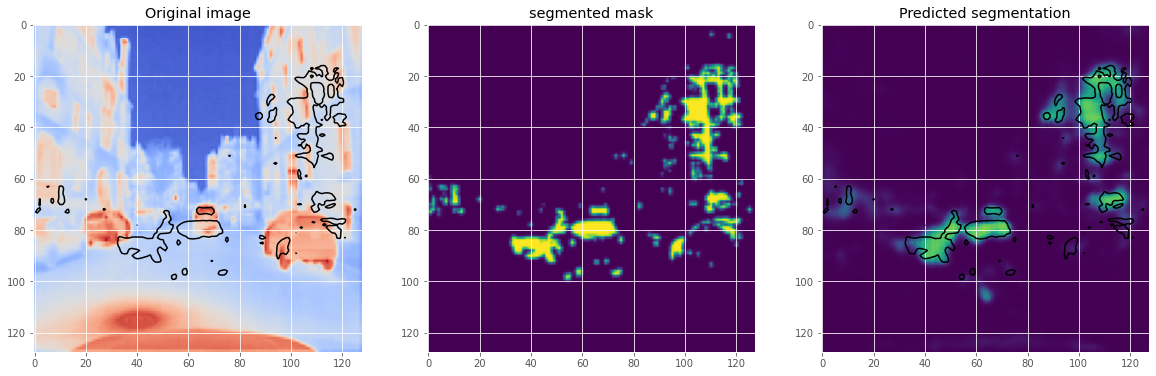

In [31]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)


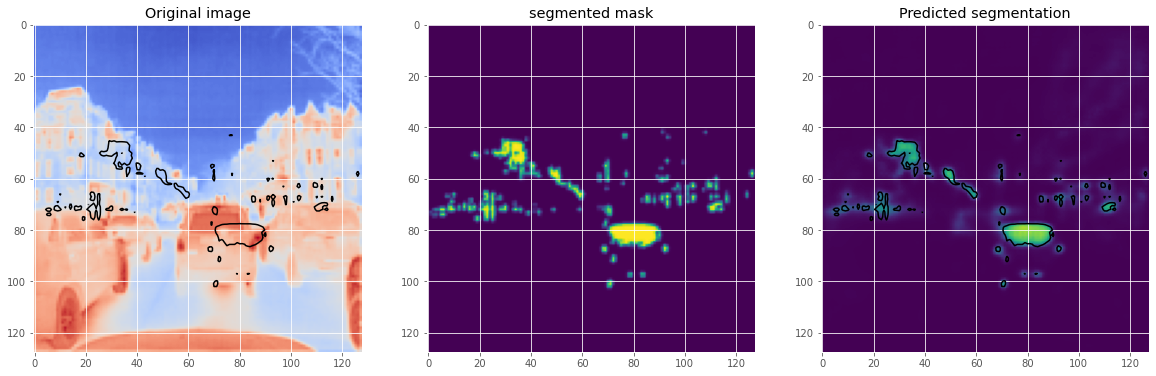

In [32]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)
